In [112]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

from datetime import datetime
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [113]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [114]:
# train.head()

start_node_name과 end_node_name으로 고유 도로 만들기

In [115]:
train[(train['start_node_name'] == '가동') & (train['end_node_name'] != '나동')]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
431,TRAIN_0000431,20211226,일,9,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,27.0
1440,TRAIN_0001440,20220128,금,16,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,11.0
1555,TRAIN_0001555,20220212,토,19,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,30.0
1886,TRAIN_0001886,20220208,화,0,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,40.0
3681,TRAIN_0003681,20210915,수,6,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697581,TRAIN_4697581,20220527,금,22,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,16.0
4698463,TRAIN_4698463,20220510,화,21,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,원일공사,33.417801,126.264684,없음,20.0
4699923,TRAIN_4699923,20220107,금,20,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,23.0
4699926,TRAIN_4699926,20220221,월,13,1,107,-,0,0,50.0,...,0,가동,33.418412,126.268029,없음,수원씽크공장,33.420614,126.273077,없음,27.0


In [116]:
train['start_end_node_name'] = train['start_node_name'].astype(str) + '-' + train['end_node_name'].astype(str)
test['start_end_node_name'] = test['start_node_name'].astype(str) + '-' + test['end_node_name'].astype(str)

In [117]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,start_end_node_name
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,산지2교-제주은행사거리
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,중문입구-관광단지입구
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,도순3교-도순2교
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,아라주공아파트-인다마을
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,부록교 시종점-봉개교 시종점


In [118]:
train.drop(["start_node_name", "end_node_name"], axis = 1, inplace = True)
test.drop(["start_node_name", "end_node_name"], axis = 1, inplace = True)

over 과속 구간 레벨 컬럼 추가

In [119]:
overspeed = train.groupby('start_end_node_name')['target'].mean()- \
    train.groupby('start_end_node_name')['maximum_speed_limit'].mean()
overspeed = overspeed.reset_index()
overspeed = overspeed.rename(columns={0:'over_speed'})


In [120]:

# 양수값 추출
positive_values = overspeed[overspeed['over_speed'] > 0]['over_speed'].values

# 양수값 정렬
sorted_values = np.sort(positive_values)

# 4분위수 계산
q1 = np.percentile(sorted_values, 25)
q2 = np.percentile(sorted_values, 50)
q3 = np.percentile(sorted_values, 75)

# 'level' 컬럼 추가 및 값 할당
overspeed['over_speed_level'] = 0  # 음수에는 0 할당

overspeed.loc[(overspeed['over_speed'] <= q1) & (overspeed['over_speed'] >= 0), 'over_speed_level'] = 1
overspeed.loc[(overspeed['over_speed'] > q1) & (overspeed['over_speed'] <= q2), 'over_speed_level'] = 2
overspeed.loc[(overspeed['over_speed'] > q2) & (overspeed['over_speed'] <= q3), 'over_speed_level'] = 3
overspeed.loc[overspeed['over_speed'] > q3, 'over_speed_level'] = 4

In [121]:
overspeed[overspeed['start_end_node_name'] == '양계장-구엄교']

,start_end_node_name,over_speed,over_speed_level
438,양계장-구엄교,26.903359,4


In [122]:
overspeed[overspeed['start_end_node_name'] == '전표1교-동광1교차로']

,start_end_node_name,over_speed,over_speed_level
585,전표1교-동광1교차로,7.712526,3


In [123]:
train = train.merge(overspeed, on='start_end_node_name', how='left')
test = test.merge(overspeed, on='start_end_node_name', how='left')

In [124]:
# train = train.drop(['over_speed'], axis=1)
# test = test.drop(['over_speed'], axis=1)

### Feature Engineering

In [125]:
# 한 가지 값만 존재하는 컬럼 
one_value = []
for i in train.columns:
    if len(train[i].value_counts()) <2:
        one_value.append(i)
one_value

['vehicle_restricted', 'height_restricted']

In [126]:
# vehicle_restricted, height_restricted 컬럼 삭제
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [127]:
# multi_linked 컬럼 삭제
train.drop(columns='multi_linked', axis=1, inplace=True)
test.drop(columns='multi_linked', axis=1, inplace=True)

In [128]:
# year, month 컬럼 추가
train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month

test["datetime"] = pd.to_datetime(test["base_date"],format='%Y%m%d')
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month

In [129]:
# 시간 나누기 
train.loc[(train['base_hour'] < 6), 'group_time'] = '새벽'
train.loc[(train['base_hour'] >=6) & (train['base_hour'] < 12), 'group_time'] = '아침'
train.loc[(train['base_hour'] >= 12) & (train['base_hour'] < 18), 'group_time'] = '점심'
train.loc[(train['base_hour'] >= 18) & (train['base_hour'] <= 24), 'group_time'] = '저녁'

test.loc[(test['base_hour'] < 6), 'group_time'] = '새벽'
test.loc[(test['base_hour'] >=6) & (test['base_hour'] < 12), 'group_time'] = '아침'
test.loc[(test['base_hour'] >= 12) & (test['base_hour'] < 18), 'group_time'] = '점심'
test.loc[(test['base_hour'] >= 18) & (test['base_hour'] <= 24), 'group_time'] = '저녁'

In [130]:
# day_weight 컬럼 추가
train['day_weight'] = 0

train.loc[(train['day_of_week'] == '금'),'day_weight'] = 3
train.loc[(train['day_of_week'] == '토')|(train['day_of_week'] == '일'),'day_weight'] = 1
train.loc[(train['day_of_week'] == '월')|(train['day_of_week'] == '화')|\
    (train['day_of_week'] == '수')|(train['day_of_week'] == '목'),'day_weight'] = 2

test['day_weight'] = 0

test.loc[(test['day_of_week'] == '금'),'day_weight'] = 3
test.loc[(test['day_of_week'] == '토')|(test['day_of_week'] == '일'),'day_weight'] = 1
test.loc[(test['day_of_week'] == '월')|(test['day_of_week'] == '화')|\
    (test['day_of_week'] == '수')|(test['day_of_week'] == '목'),'day_weight'] = 2


In [131]:
# 제주도 기온, 강수 csv 파일 불러오기
def read_csv_jeju(filename):
    filename = pd.read_csv(f"./data/{filename}.csv")
    filename['날짜'] = filename['날짜'].str.replace('\t','')
    filename["날짜"] = pd.to_datetime(filename["날짜"],format='%Y-%m-%d')
    filename = filename.rename(columns={'날짜':'datetime'})
    return filename

In [21]:
temper = read_csv_jeju('temperature_jeju')[['datetime','평균기온(℃)']]
rain = read_csv_jeju('rain_jeju')[['datetime','강수량(mm)']]
rain['강수량(mm)'] = rain['강수량(mm)'].fillna(0)
# train = pd.merge(train, temper, on='datetime', how='left')
# train
temper.tail()

,datetime,평균기온(℃)
360,2022-08-27,30.4
361,2022-08-28,28.4
362,2022-08-29,28.0
363,2022-08-30,32.7
364,2022-08-31,29.1


In [22]:
temp_rain = pd.merge(temper, rain, on='datetime', how='inner')
train = pd.merge(train, temp_rain, left_on='datetime', right_on='datetime', how='inner')


In [23]:
test = pd.merge(test, temp_rain, left_on='datetime', right_on='datetime', how='inner')

In [28]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_end_node_name,over_speed,over_speed_level,datetime,year,month,group_time,day_weight,평균기온(℃),강수량(mm)
0,TEST_000000,20220825,목,17,3,107,연삼로,0,70.0,0.0,...,산지2교-제주은행사거리,-36.376836,0,2022-08-25,2022,8,점심,2,30.7,0.0
1,TEST_000030,20220825,목,2,1,107,중문로,0,50.0,0.0,...,덕진건재-자운당교,-11.617869,0,2022-08-25,2022,8,새벽,2,30.7,0.0
2,TEST_000035,20220825,목,0,3,103,일반국도12호선,0,50.0,0.0,...,오현고앞삼거리-거로마을,-16.788746,0,2022-08-25,2022,8,새벽,2,30.7,0.0
3,TEST_000039,20220825,목,8,2,103,일반국도12호선,0,70.0,0.0,...,효례교-청송낚시,-27.177293,0,2022-08-25,2022,8,아침,2,30.7,0.0
4,TEST_000040,20220825,목,11,2,107,새서귀로,0,60.0,0.0,...,부동산-오름식당,-32.114171,0,2022-08-25,2022,8,아침,2,30.7,0.0


In [132]:
train = pd.get_dummies(train,columns=['day_of_week','group_time'])
test = pd.get_dummies(test,columns=['day_of_week','group_time'])

In [93]:
# 제주 공항으로 부터의 거리를 L1, L2 로 구하여 feature로 추가
# 제주공항 gps : 33.510752, 126.492199
train['distance_from_airport_square'] = (train['end_latitude'] - 33.510752)**2 + (train['end_longitude'] - 126.492199)**2
# train['distance_from_airport_abs'] = abs((train['end_latitude'] - 33.510752)) + abs((train['end_longitude'] - 126.492199))

test['distance_from_airport_square'] = (test['end_latitude'] - 33.510752)**2 + (test['end_longitude'] - 126.492199)**2
# test['distance_from_airport_abs'] = abs((test['end_latitude'] - 33.510752)) + abs((test['end_longitude'] - 126.492199))

In [136]:
train.head()

,id,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,...,day_of_week_목,day_of_week_수,day_of_week_월,day_of_week_일,day_of_week_토,day_of_week_화,group_time_새벽,group_time_아침,group_time_저녁,group_time_점심
0,TRAIN_0000000,17,1,106,지방도1112호선,0,60.0,32400.0,3,33.427747,...,True,False,False,False,False,False,False,False,False,True
1,TRAIN_0000001,21,2,103,일반국도11호선,0,60.0,0.0,0,33.500730,...,True,False,False,False,False,False,False,False,True,False
2,TRAIN_0000002,7,2,103,일반국도16호선,0,80.0,0.0,0,33.279145,...,False,False,False,True,False,False,False,True,False,False
3,TRAIN_0000003,13,2,107,태평로,0,50.0,0.0,0,33.246081,...,False,False,False,False,False,False,False,False,False,True
4,TRAIN_0000004,8,2,103,일반국도12호선,0,80.0,0.0,0,33.462214,...,False,False,False,False,False,True,False,True,False,False


In [133]:
train.drop(["base_date"], axis = 1, inplace = True)
test.drop(["base_date"], axis = 1, inplace = True)

In [96]:
# # 생짜배기 라벨인코더
# from sklearn.preprocessing import LabelEncoder

# items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted','start_node_name','end_node_name']
# train_label = train.copy()
# encoder = LabelEncoder()

# for i in items:
#     encoder = LabelEncoder()
#     encoder.fit(train_label[i])
#     train_label[i] = encoder.transform(train_label[i])

# items =  ['day_of_week', 'road_name', 'start_turn_restricted', 'end_turn_restricted','start_node_name','end_node_name']
# test_label = test.copy()
# encoder = LabelEncoder()

# for i in items:
#     encoder = LabelEncoder()
#     encoder.fit(test_label[i])
#     test_label[i] = encoder.transform(test_label[i])

In [139]:
from sklearn.preprocessing import LabelEncoder
# day_of_week, group_time
items =  ['road_name', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])
# day_of_week, group_time

items =  ['road_name', 'start_turn_restricted', 'end_turn_restricted', 'start_end_node_name']
test_label = test.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(test_label[i])
    test_label[i] = encoder.transform(test_label[i])

In [140]:
train_label.head(2)

,id,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,...,day_of_week_목,day_of_week_수,day_of_week_월,day_of_week_일,day_of_week_토,day_of_week_화,group_time_새벽,group_time_아침,group_time_저녁,group_time_점심
0,TRAIN_0000000,17,1,106,46,0,60.0,32400.0,3,33.427747,...,True,False,False,False,False,False,False,False,False,True
1,TRAIN_0000001,21,2,103,34,0,60.0,0.0,0,33.500730,...,True,False,False,False,False,False,False,False,True,False


In [4]:
# 생짜배기 트레인스플릿 삭제해도되는 코드
y_train = train_label['target'] 
X_train = train_label.drop(['id', 'target','road_name','vehicle_restricted'], axis=1)

X_test = test_label.drop(['id', 'road_name','vehicle_restricted'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 19)
(4701217,)
(291241, 22)


In [141]:
y_train = train_label['target'] 
X_train = train_label.drop(['id', 'target','road_name','datetime'], axis=1)

X_test = test_label.drop(['id', 'road_name','datetime'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 30)
(4701217,)
(291241, 33)


In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)

,base_hour,lane_count,road_rating,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,...,day_of_week_목,day_of_week_수,day_of_week_월,day_of_week_일,day_of_week_토,day_of_week_화,group_time_새벽,group_time_아침,group_time_저녁,group_time_점심
0,0.754498,1.691525,1.109446,-0.050886,0.72087,-0.402678,-0.507917,1.137435,0.125438,-0.329933,...,2.444253,-0.409659,-0.40471,-0.408968,-0.407597,-0.405014,-0.52249,-0.588882,-0.589,1.642237
1,0.010682,0.237511,-1.064340,-0.050886,0.72087,-0.402678,1.968826,-1.243157,-0.605507,-0.329933,...,-0.409123,-0.409659,-0.40471,-0.408968,-0.407597,2.469048,-0.52249,-0.588882,-0.589,1.642237


In [143]:
from sklearn.model_selection import train_test_split
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
#                                             stratify=train['base_hour'], random_state=2021)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 30) (3760973,)
(940244, 30) (940244,)


In [27]:
import lightgbm as lgb

start_time = time.time()

params = {'learning_rate': 0.2,
                    'max_depth': 15,
                    'n_estimators': 200,
                    'num_leaves': 30}
LR = lgb.LGBMRegressor(random_state=42, **params).fit(X_tr, y_tr,eval_set=[(X_val, y_val)],verbose=10) 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# 최적의 에포크 수 확인
best_num_boost_round = LR.best_iteration_
print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, LR.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, LR.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, LR.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, LR.predict(X_val))}")


[10]	valid_0's l2: 71.429
[20]	valid_0's l2: 53.7467
[30]	valid_0's l2: 46.3062
[40]	valid_0's l2: 42.1269
[50]	valid_0's l2: 38.7661
[60]	valid_0's l2: 36.7566
[70]	valid_0's l2: 34.7564
[80]	valid_0's l2: 33.1561
[90]	valid_0's l2: 32.0435
[100]	valid_0's l2: 31.1938
[110]	valid_0's l2: 30.5283
[120]	valid_0's l2: 29.7726
[130]	valid_0's l2: 29.2456
[140]	valid_0's l2: 28.8438
[150]	valid_0's l2: 28.2324
[160]	valid_0's l2: 27.7314
[170]	valid_0's l2: 27.4187
[180]	valid_0's l2: 27.1277
[190]	valid_0's l2: 26.8381
[200]	valid_0's l2: 26.5822
Best number of boosting rounds: None
Fit time :  22.005642890930176
tr mae: 3.7445013704870815
val mae: 3.7552115196177467
tr r2_score: 0.8964340495347228
val r2_score: 0.895592283056248


In [22]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# LightGBM 모델 정의
model = lgb.LGBMRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 20, 30],
    'max_depth': [5, 10, 15]
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'num_leaves': 30}
Best Score: 3.7429492754643348


In [29]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost 모델 정의
model = xgb.XGBRegressor(random_state=42,)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 1/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.677 total time=  50.0s
[CV 2/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 2/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.663 total time= 1.3min
[CV 3/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 3/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6;, score=-25.687 total time= 1.9min
[CV 4/5; 1/243] START colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6
[CV 4/5; 1/243] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_esti

KeyboardInterrupt: 

In [215]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

start_time = time.time()
xgb_model = xgb.XGBRegressor(random_state=42)

# 조기 종료를 위한 검증 세트 설정
eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 조기 종료 및 학습
xgb_model.fit(X_tr, y_tr,
              eval_set=eval_set,
              eval_metric='mae',
              early_stopping_rounds=10,
              verbose=10)

# 최적의 에포크 수 확인
best_num_boost_round = xgb_model.best_iteration
print("Best number of boosting rounds:", best_num_boost_round)

# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-mae:29.61072	validation_1-mae:29.62628
[10]	validation_0-mae:4.40021	validation_1-mae:4.39595
[20]	validation_0-mae:4.11329	validation_1-mae:4.11199
[30]	validation_0-mae:3.98932	validation_1-mae:3.98906
[40]	validation_0-mae:3.90679	validation_1-mae:3.90742
[50]	validation_0-mae:3.83388	validation_1-mae:3.83458
[60]	validation_0-mae:3.77905	validation_1-mae:3.78070
[70]	validation_0-mae:3.71251	validation_1-mae:3.71552
[80]	validation_0-mae:3.67355	validation_1-mae:3.67739
[90]	validation_0-mae:3.63115	validation_1-mae:3.63578
[99]	validation_0-mae:3.60135	validation_1-mae:3.60663
Best number of boosting rounds: 99
Best number of boosting rounds: 99
Fit time :  276.9179730415344
tr mae: 3.6013526247590772
val mae: 3.6066301839028836
tr r2_score: 0.9013594957982527
val r2_score: 0.9010292587987687


In [216]:
print("Best number of boosting rounds:", best_num_boost_round)
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

Best number of boosting rounds: 99
Fit time :  364.093150138855
tr mae: 3.6013526247590772
val mae: 3.6066301839028836
tr r2_score: 0.9013594957982527
val r2_score: 0.9010292587987687


In [144]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

params = {'colsample_bytree': 1.0,
            'learning_rate': 0.1,
            'max_depth': 15,
            'n_estimators': 200,
            'subsample': 1.0}
            
start_time = time.time()
xgb_model = xgb.XGBRegressor(random_state=42, **params)

# 조기 종료를 위한 검증 세트 설정
eval_set = [(X_tr, y_tr), (X_val, y_val)]

# 조기 종료 및 학습
xgb_model.fit(X_tr, y_tr,eval_set=eval_set,verbose=10)


# 평가
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-rmse:40.74355	validation_1-rmse:40.71309
[10]	validation_0-rmse:14.89524	validation_1-rmse:14.89440
[20]	validation_0-rmse:6.70074	validation_1-rmse:6.75030
[30]	validation_0-rmse:4.70258	validation_1-rmse:4.82908
[40]	validation_0-rmse:4.30681	validation_1-rmse:4.49742
[50]	validation_0-rmse:4.18752	validation_1-rmse:4.43240
[60]	validation_0-rmse:4.12128	validation_1-rmse:4.41364
[70]	validation_0-rmse:4.06804	validation_1-rmse:4.40177
[80]	validation_0-rmse:4.02783	validation_1-rmse:4.39419
[90]	validation_0-rmse:3.99688	validation_1-rmse:4.39108
[100]	validation_0-rmse:3.97402	validation_1-rmse:4.38844
[110]	validation_0-rmse:3.95389	validation_1-rmse:4.38655
[120]	validation_0-rmse:3.93901	validation_1-rmse:4.38619
[130]	validation_0-rmse:3.92167	validation_1-rmse:4.38569
[140]	validation_0-rmse:3.90531	validation_1-rmse:4.38519
[150]	validation_0-rmse:3.88850	validation_1-rmse:4.38593
[160]	validation_0-rmse:3.87352	validation_1-rmse:4.38664
[170]	validation_0-rm

In [103]:
# 평가
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, xgb_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, xgb_model.predict(X_val))}")

Fit time :  3007.4686317443848
tr mae: 2.6568984243392815
val mae: 3.0125349837146187
tr r2_score: 0.9423547704443521
val r2_score: 0.9235916325427667


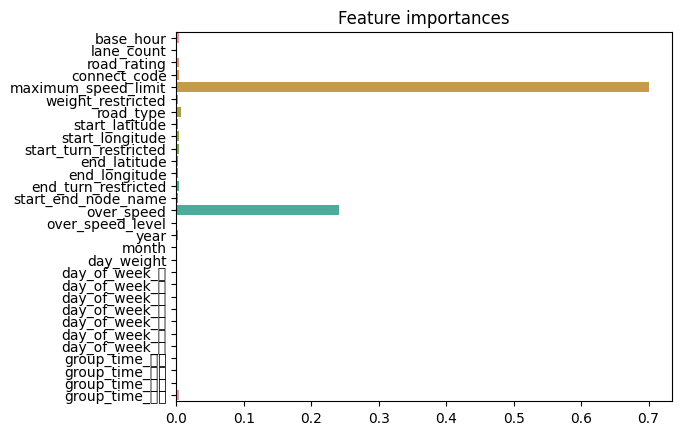

In [145]:
feature_names = X_train.columns
importances = xgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

Text(0.5, 0, 'Xgboost Feature Importance')

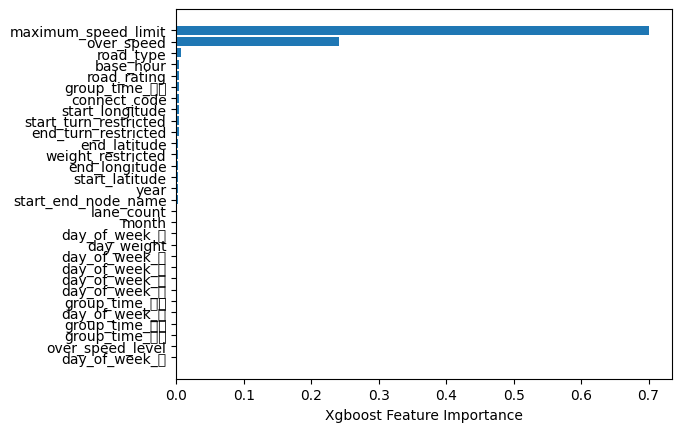

In [146]:
feature_names = X_train.columns
xgb_model.feature_importances_
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")


In [148]:
xgb_pred = xgb_model.predict(X_test)
submission_xgb = pd.read_csv('./data/sample_submission.csv')
submission_xgb['target'] = xgb_pred
submission_xgb.to_csv("./data/submit_xgb2.csv", index = False)

In [104]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=50000, 
                              num_leaves = 128, 
                              subsample=0.6,
                              colsample_bytree=0.7,
                              reg_lambda=15,
                              random_state=20)


lgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                verbose=500,
                early_stopping_rounds=500)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, lgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")

[500]	valid_0's l1: 3.23318	valid_0's l2: 21.3166
[1000]	valid_0's l1: 3.15029	valid_0's l2: 20.5085
[1500]	valid_0's l1: 3.1126	valid_0's l2: 20.1361
[2000]	valid_0's l1: 3.09134	valid_0's l2: 19.9237
[2500]	valid_0's l1: 3.07784	valid_0's l2: 19.7868
[3000]	valid_0's l1: 3.06624	valid_0's l2: 19.6714
[3500]	valid_0's l1: 3.05869	valid_0's l2: 19.598
[4000]	valid_0's l1: 3.05138	valid_0's l2: 19.5248
[4500]	valid_0's l1: 3.04618	valid_0's l2: 19.476
[5000]	valid_0's l1: 3.04127	valid_0's l2: 19.428
[5500]	valid_0's l1: 3.03761	valid_0's l2: 19.3943
[6000]	valid_0's l1: 3.03434	valid_0's l2: 19.3655
[6500]	valid_0's l1: 3.03158	valid_0's l2: 19.3403
[7000]	valid_0's l1: 3.02938	valid_0's l2: 19.3217
[7500]	valid_0's l1: 3.02759	valid_0's l2: 19.3072
[8000]	valid_0's l1: 3.02594	valid_0's l2: 19.2958
[8500]	valid_0's l1: 3.0245	valid_0's l2: 19.2863
[9000]	valid_0's l1: 3.02361	valid_0's l2: 19.2827
[9500]	valid_0's l1: 3.02267	valid_0's l2: 19.2769
[10000]	valid_0's l1: 3.02194	valid_0

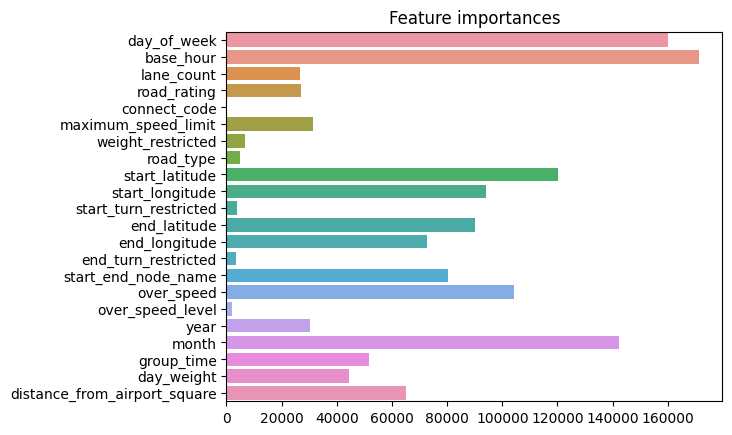

In [105]:
feature_names = X_train.columns
importances = lgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

In [147]:
lgb_pred = lgb_model.predict(X_test)
submission_lgb = pd.read_csv('./data/sample_submission.csv')
submission_lgb['target'] = lgb_pred
submission_lgb.to_csv("./data/submit_lgb2.csv", index = False)

ValueError: Number of features of the model must match the input. Model n_features_ is 22 and input n_features is 30

In [73]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['target'] = np.round((submission_xgb['target'] + submission_lgb['target'])  / 2)
sample_submission.to_csv("./data/submit_final.csv", index = False)  

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree 모델 정의
model = DecisionTreeRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5,verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.676 total time=  27.7s
[CV 2/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.667 total time=  28.0s
[CV 3/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.671 total time=  27.1s
[CV 4/5; 1/108] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 1/108] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2;, score=-3.682 total time=  26.8s
[CV 5/5; 1/108] START max_depth=N

In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

start_time = time.time()
# Decision Tree 모델 생성 및 학습
params = {'max_depth': None, 
            'max_features': None, 
            'min_samples_leaf': 4, 
            'min_samples_split': 10}

tree_model = DecisionTreeRegressor(random_state=42, **params)

tree_model.fit(X_tr, y_tr)

# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, tree_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, tree_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, tree_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, tree_model.predict(X_val))}")

Fit time :  30.92632484436035
tr mae: 2.569532177266598
val mae: 3.223611695437014
tr r2_score: 0.9448637679637532
val r2_score: 0.9130118257634173


In [84]:
print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, tree_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, tree_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, tree_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, tree_model.predict(X_val))}")

Fit time :  139.98461198806763
tr mae: 0.0
val mae: 3.451992248820519
tr r2_score: 1.0
val r2_score: 0.880861639038405


In [88]:
(y_tr != tree_model.predict(X_tr)).sum()

0

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# RandomForestRegressor 모델 정의
model = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV를 사용하여 하이퍼파라미터 최적화
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=10)
grid_search.fit(X_tr, y_tr)

# 최적의 하이퍼파라미터와 최적 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# 최적 모델 추출
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


KeyboardInterrupt: 

In [217]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

start_time = time.time()
# Random Forest 모델 생성 및 학습
rf_model = RandomForestRegressor(random_state=42,verbose=1)
rf_model.fit(X_tr, y_tr)


# 평가
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

print('Fit time : ', time.time() - start_time)
print(f"tr mae: {mean_absolute_error(y_tr, rf_model.predict(X_tr))}")
print(f"val mae: {mean_absolute_error(y_val, rf_model.predict(X_val))}")
print(f"tr r2_score: {r2_score(y_tr, rf_model.predict(X_tr))}")
print(f"val r2_score: {r2_score(y_val, rf_model.predict(X_val))}")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 54.5min finished


Fit time :  3268.600010871887


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.1min finished


tr mae: 1.029726132040831


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


val mae: 2.7750409787246695


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.4min finished


tr r2_score: 0.9906183511223293


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


val r2_score: 0.9328916593052162


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished
